In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from os import listdir
from os.path import isfile, join
import os
import math

In [3]:
def sigmoid(Z):

    A = 1/(1+np.exp(-Z))
    cache = Z
    return A,cache

In [4]:
def relu(Z):
    A = np.maximum(0,Z)
    cache = Z 
    return A,cache

In [5]:
def sigmoid_backward(dA, cache):
   
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    return dZ

In [6]:
def relu_backward(dA, cache):
    
    Z = cache
    
    dZ = np.array(dA, copy=True)  
    dZ[Z <= 0] = 0
     
    return dZ

In [7]:
def initialize_parameters(layer_dims):
    parameters = {}
    L = len(layer_dims)           

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])*  np.sqrt(2 / layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
    return parameters

In [8]:
def linear_activation_forward(A_prev, W, b, activation):
    
    if activation == "sigmoid":
        
        Z = np.dot(W,A_prev)+b
        linear_cache = (A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        print(W.shape,A_prev.shape)
       
    elif activation == "relu":
       
        Z = np.dot(W,A_prev)+b
        linear_cache = (A_prev, W, b)
        A, activation_cache = relu(Z)
        
    cache = (linear_cache, activation_cache)
    del linear_cache
    del activation_cache
    del Z
    #print(cache[1])
    return A, cache


In [9]:
def forward_propagation(X, parameters):
    caches=[]
    A_prev=X
    L = len(parameters) // 2
    for l in range(1,L):
        A_prev,cache=linear_activation_forward(A_prev,parameters['W'+str(l)],parameters['b'+str(l)],'relu')
        caches.append(cache)
    AL,cache=linear_activation_forward(A_prev,parameters['W'+str(L)],parameters['b'+str(L)],'sigmoid')
    caches.append(cache)
    del cache
    del A_prev
    del L
    return AL, caches

In [10]:
def compute_cost(AL, Y):
    
    m = Y.shape[1]
    cost = -(1/m)*np.sum(Y*np.log(AL)+(1-Y)*np.log(1-AL))
    cost = np.squeeze(cost)      
    
    return cost

In [11]:
def linear_backward(dZ, cache):
    
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = np.dot(dZ,A_prev.T)/m
    db = np.sum(dZ,axis=1,keepdims=True)/m
    dA_prev = np.dot(W.T,dZ)
    del A_prev
    del W
    del b
    return dA_prev, dW, db

In [12]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA,activation_cache)
        dA_prev, dW, db =linear_backward(dZ,linear_cache) 
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
    del dZ
    del linear_cache
    del activation_cache
    return dA_prev, dW, db

In [13]:
def backward_propagation(AL, Y, caches):
    grads = {}
    L = len(caches) 
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] =linear_activation_backward(dAL, current_cache, 'sigmoid')
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, 'relu')
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    del dA_prev_temp, dW_temp, db_temp
    del dAL
    del L,m,Y
    del current_cache
    return grads

In [14]:
def update_parameters(parameters, grads, learning_rate):
    
    L = len(parameters) 
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)]-learning_rate*grads['dW'+str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]-learning_rate*grads['db'+str(l+1)]
    del L
    return parameters

In [15]:
def update_parameters_with_gd(parameters, grads, learning_rate):

    L = len(parameters) // 2 

    for l in range(L):

        parameters["W" + str(l+1)] = parameters['W'+str(l+1)]-learning_rate*grads['dW'+str(l+1)]
        parameters["b" + str(l+1)] = parameters['b'+str(l+1)]-learning_rate*grads['db'+str(l+1)]
    del L  
    return parameters

In [16]:
def random_mini_batches(X, Y, mini_batch_size = 64):
             
    m = X.shape[1]                 
    mini_batches = []

    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

    num_complete_minibatches = math.floor(m/mini_batch_size) 
    for k in range(0, num_complete_minibatches):
        
        mini_batch_X = shuffled_X[:,k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:,k*mini_batch_size:(k+1)*mini_batch_size]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    if m % mini_batch_size != 0:
        
        mini_batch_X = shuffled_X[:,math.floor(m/mini_batch_size)*mini_batch_size:]
        mini_batch_Y = shuffled_Y[:,math.floor(m/mini_batch_size)*mini_batch_size:]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    del permutation,m
    del mini_batch_X,mini_batch_Y
    return mini_batches

In [17]:
def initialize_velocity(parameters):
    
    L = len(parameters) // 2 
    v = {}
    
    for l in range(L):
        
        v["dW" + str(l+1)] = np.zeros(parameters['W'+str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters['b'+str(l+1)].shape)
    del L
    return v

In [18]:
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    
    L = len(parameters) // 2 
    for l in range(L):

        v["dW" + str(l+1)] = beta*v['dW'+str(l+1)]+(1-beta)*grads['dW'+str(l+1)]
        v["db" + str(l+1)] = beta*v['db'+str(l+1)]+(1-beta)*grads['db'+str(l+1)]
       
        parameters["W" + str(l+1)] = parameters['W'+str(l+1)]-learning_rate*v['dW'+str(l+1)]
        parameters["b" + str(l+1)] = parameters['b'+str(l+1)]-learning_rate*v['db'+str(l+1)]
    
    return parameters, v

In [19]:
def initialize_adam(parameters) :
    
    L = len(parameters) // 2 
    v = {}
    s = {}
    
    for l in range(L):
    
        v["dW" + str(l+1)] = np.zeros(parameters['W'+str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters['b'+str(l+1)].shape)
        s["dW" + str(l+1)] = np.zeros(parameters['W'+str(l+1)].shape)
        s["db" + str(l+1)] = np.zeros(parameters['b'+str(l+1)].shape)
    del L
    return v, s

In [20]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    
    L = len(parameters) // 2                 
    v_corrected = {}                         
    s_corrected = {}                         

    for l in range(L):

        v["dW" + str(l + 1)] = beta1 * v["dW" + str(l + 1)] + (1 - beta1) * grads['dW' + str(l + 1)]
        v["db" + str(l + 1)] = beta1 * v["db" + str(l + 1)] + (1 - beta1) * grads['db' + str(l + 1)]
        
        v_corrected["dW" + str(l + 1)] = v["dW" + str(l + 1)] / (1 - np.power(beta1, t))
        v_corrected["db" + str(l + 1)] = v["db" + str(l + 1)] / (1 - np.power(beta1, t))
        
        s["dW" + str(l + 1)] = beta2 * s["dW" + str(l + 1)] + (1 - beta2) * np.power(grads['dW' + str(l + 1)], 2)
        s["db" + str(l + 1)] = beta2 * s["db" + str(l + 1)] + (1 - beta2) * np.power(grads['db' + str(l + 1)], 2)

        s_corrected["dW" + str(l + 1)] = s["dW" + str(l + 1)] / (1 - np.power(beta2, t))
        s_corrected["db" + str(l + 1)] = s["db" + str(l + 1)] / (1 - np.power(beta2, t))

        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * v_corrected["dW" + str(l + 1)] / np.sqrt(s_corrected["dW" + str(l + 1)] + epsilon)
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * v_corrected["db" + str(l + 1)] / np.sqrt(s_corrected["db" + str(l + 1)] + epsilon)
    del L
    return parameters, v, s

In [21]:
def predict(X, y, parameters):
   
    m = X.shape[1]
    p = np.zeros((1,m), dtype = np.int)

    a3, caches = forward_propagation(X, parameters)
  
    for i in range(0, a3.shape[1]):
        if a3[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    print("Accuracy: "  + str(np.mean((p[0,:] == y[0,:]))))
    
    return p

In [22]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.005, mini_batch_size = 64, beta = 0.9,beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 30, print_cost = True):

    L = len(layers_dims)             
    costs = []                       
    t = 0                                                   
    m = X.shape[1]                  
    parameters = initialize_parameters(layers_dims)

    if optimizer == "gd":
        pass 
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    for i in range(num_epochs):
        
        minibatches = random_mini_batches(X, Y, mini_batch_size)
        cost_total = 0
        
        for minibatch in minibatches:

            (minibatch_X, minibatch_Y) = minibatch

            a3, caches = forward_propagation(minibatch_X, parameters)
            print(a3.shape)
            cost_total += compute_cost(a3, minibatch_Y)

            grads = backward_propagation(a3, minibatch_Y, caches)

            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        cost_avg = cost_total / m
        
        if print_cost and i % 2 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 2 == 0:
            costs.append(cost_avg)
                
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

In [23]:
plastic=os.path.abspath('plastic')
onlyfiles = [ f for f in listdir(plastic) if isfile(join(plastic,f)) ]
non_plastic=os.path.abspath('non_plastic')
onlyfiles1 = [ f for f in listdir(non_plastic) if isfile(join(non_plastic,f)) ]
train_images = np.zeros((len(onlyfiles)+len(onlyfiles1),384,512,3), dtype=np.uint8)
train_labels = []
for n in range(0, len(onlyfiles)):
    train_images[n] = cv2.imread( join(plastic,onlyfiles[n]),1 )
    train_labels.append(1)

for n in range(0, len(onlyfiles1)):
    train_images[len(onlyfiles)+n] = cv2.imread( join(non_plastic,onlyfiles1[n]),1 )
    train_labels.append(0)

train_labels=[train_labels]
train_labels_array=np.asarray(train_labels)
#print(train_labels_array.shape)

In [24]:
plastic_test=os.path.abspath('plastic_test')
onlyfiles_test = [ f for f in listdir(plastic_test) if isfile(join(plastic_test,f)) ]
non_plastic_test=os.path.abspath('non_plastic_test')
onlyfiles_test1 = [ f for f in listdir(non_plastic_test) if isfile(join(non_plastic_test,f)) ]
test_images = np.zeros((len(onlyfiles_test)+len(onlyfiles_test1),384,512,3), dtype=np.uint8)
test_labels = []
for n in range(0, len(onlyfiles_test)):
    test_images[n] = cv2.imread( join(plastic_test,onlyfiles_test[n]),1 )
    test_labels.append(1)

for n in range(0, len(onlyfiles_test1)):
    test_images[len(onlyfiles_test)+n] = cv2.imread( join(non_plastic_test,onlyfiles_test1[n]),1 )
    test_labels.append(0)

test_labels=[test_labels]
test_labels_array=np.asarray(test_labels)
print(train_labels_array.shape)

(1, 545)


In [25]:
train_x_flatten = train_images.reshape(train_images.shape[0],-1).T
print(train_images.shape)
train_x = train_x_flatten/255
print(train_x.shape)

(545, 384, 512, 3)
(589824, 545)


In [26]:
test_x_flatten = test_images.reshape(test_images.shape[0],-1).T
test_x = test_x_flatten/255
#print(test_x.shape)

(1, 10) (10, 64)
(1, 64)
(1, 10) (10, 64)
(1, 64)


C:\Users\putlu\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\putlu\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.
C:\Users\putlu\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\putlu\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\putlu\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


(1, 10) (10, 64)
(1, 64)


C:\Users\putlu\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


(1, 10) (10, 64)
(1, 64)
(1, 10) (10, 64)
(1, 64)
(1, 10) (10, 64)
(1, 64)
(1, 10) (10, 64)
(1, 64)
(1, 10) (10, 64)
(1, 64)
(1, 10) (10, 33)
(1, 33)
Cost after epoch 0: nan
(1, 10) (10, 64)
(1, 64)
(1, 10) (10, 64)
(1, 64)
(1, 10) (10, 64)
(1, 64)
(1, 10) (10, 64)
(1, 64)
(1, 10) (10, 64)
(1, 64)
(1, 10) (10, 64)
(1, 64)
(1, 10) (10, 64)
(1, 64)
(1, 10) (10, 64)
(1, 64)
(1, 10) (10, 33)
(1, 33)
(1, 10) (10, 64)
(1, 64)
(1, 10) (10, 64)
(1, 64)
(1, 10) (10, 64)
(1, 64)
(1, 10) (10, 64)
(1, 64)
(1, 10) (10, 64)
(1, 64)
(1, 10) (10, 64)
(1, 64)
(1, 10) (10, 64)
(1, 64)
(1, 10) (10, 64)
(1, 64)
(1, 10) (10, 33)
(1, 33)
Cost after epoch 2: nan
(1, 10) (10, 64)
(1, 64)
(1, 10) (10, 64)
(1, 64)
(1, 10) (10, 64)
(1, 64)
(1, 10) (10, 64)
(1, 64)
(1, 10) (10, 64)
(1, 64)
(1, 10) (10, 64)
(1, 64)
(1, 10) (10, 64)
(1, 64)
(1, 10) (10, 64)
(1, 64)
(1, 10) (10, 33)
(1, 33)
(1, 10) (10, 64)
(1, 64)
(1, 10) (10, 64)
(1, 64)
(1, 10) (10, 64)
(1, 64)
(1, 10) (10, 64)
(1, 64)
(1, 10) (10, 64)
(1, 64)
(1

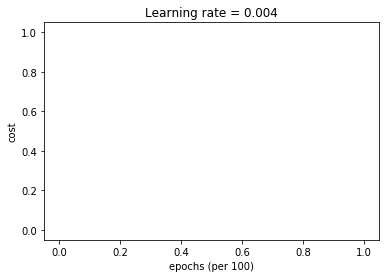

(1, 10) (10, 545)
Accuracy: 0.5761467889908257
(1, 10) (10, 295)
Accuracy: 0.688135593220339


In [27]:
layers_dims = [train_x.shape[0], 50, 20, 10,1]
parameters = model(train_x, train_labels_array, layers_dims, optimizer = "adam",learning_rate = 0.004, num_epochs = 8)

predictions = predict(train_x, train_labels_array, parameters)
predictions = predict(test_x, test_labels_array, parameters)

